All about TimeSeries and ML

1. Time Series Machine Learning Regression Framework
https://www.machinelearningmastery.ru/time-series-machine-learning-regression-framework-9ea33929009a/ rus
https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a / eng

2. Great notebook (rus language over there in root)
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb eng


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm, tqdm_notebook

import torch
from torch import nn
from torch.nn import functional as F
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR

from torch.utils.data import TensorDataset, DataLoader

## Download the data

In [2]:
data_train = pd.read_csv('DATA/train.csv', sep = ';')
data_train.date = pd.to_datetime(data_train.date, dayfirst = True)
data_test = pd.read_csv('DATA/test.csv')
data_test.date = pd.to_datetime(data_test.date, dayfirst = True)
sample_submission = pd.read_csv('DATA/sample_submission.csv')

In [3]:
#data_train.info()

In [4]:
data_train.tea_value[0]

'44\xa0193,60'

'44\xa0193,60', \xa0 -- пробел в юникоде (многие значения с пробелом)

---

---

В датасете есть даты еще не наступившие. Удалим строки с ними.

In [5]:

data_train_1 = data_train.replace({',':'.', '\xa0':''}, regex = True, inplace = False)

buff = data_train_1.date.sort_values(ascending = False)

j = 0
i = buff.index[j]

while buff[i] != pd.Timestamp('2021-03-31 00:00:00'):
    j += 1
    i = buff.index[j]
    
print('Удаляем в data_train_1 все индексы до индекса {}, считая по buff.index'.format(j))

del_ind = np.array([])

for i in range(len(buff)):
    if i == j:
        break
    else:
        del_ind = np.append(del_ind, buff.index[i])

data_train_1.drop(index=del_ind, inplace=True)

for i in data_train_1.columns.drop('date'):
    data_train_1[i] = data_train_1[i].astype('float')
    
columns = data_train_1.columns.drop(['date', 'region', 'oktmo', 'okato'])

print('В таргетах {} отрицательных значений/я'.format(((data_train_1[columns] < 0).sum()).sum()))
print('В признаках {} отрицательных значений/я'.format(((data_train_1[['region', 'oktmo', 'okato']] < 0).sum()).sum()))

def ser_empty(df):
    ### проверяет, пустой ли Series
    return len(df.index) == 0
        
for col in columns:
    mask = data_train_1.copy()[col].apply(lambda x: x < 0)
    if not ser_empty(data_train_1[col][mask]):
        #print(col, data_train_1[col][mask].index)
        index = data_train_1.copy()[col][mask].index # индексы строк с отрицательными значениями
        data_train_1.loc[index, col] = data_train_1.loc[index, col]*(-1)
        
print('В таргетах {} отрицательных значений/я'.format(((data_train_1[columns] < 0).sum()).sum()))

Удаляем в data_train_1 все индексы до индекса 0, считая по buff.index
В таргетах 54 отрицательных значений/я
В признаках 0 отрицательных значений/я
В таргетах 0 отрицательных значений/я


-------

In [6]:
data_train_1.region.value_counts()

21.0    1642
72.0     821
41.0     821
92.0     821
43.0     821
        ... 
4.0      821
2.0      821
87.0     821
86.0     821
59.0     821
Name: region, Length: 84, dtype: int64

In [7]:
data_train_1.oktmo.value_counts()

7.100000e+10    821
3.000000e+10    821
6.700000e+10    821
3.300000e+10    821
3.700000e+10    821
               ... 
7.900000e+10    821
8.400000e+10    821
8.000000e+10    821
7.700000e+10    821
5.700000e+10    821
Name: oktmo, Length: 85, dtype: int64

In [8]:
data_train_1.okato.value_counts()

7.100000e+10    821
3.000000e+10    821
6.700000e+10    821
3.300000e+10    821
3.700000e+10    821
               ... 
7.900000e+10    821
8.400000e+10    821
8.000000e+10    821
7.700000e+10    821
5.700000e+10    821
Name: okato, Length: 85, dtype: int64

## Нужная нам метрика 

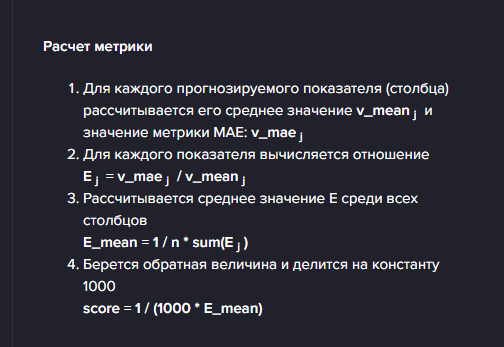

In [9]:
from torch.nn import L1Loss, MSELoss

loss_func = MSELoss()

def Score(y_pred, y_test):
    
    """ для pd.Series
    """
    v_mean = np.mean(y_pred)
    v_mae = mean_absolute_error(y_pred, y_test)
    E = v_mae / v_mean
    E_mean = np.sum(E) 
    score = 1 / (1000*E_mean)
    
    return score

def score_np(y_pred, y_test):
    
    """ для pd.DataFrame
    """
    v_mean_pred = np.mean(y_pred, axis = 1)
    v_mae = mean_absolute_error(y_pred, y_test)
    E = v_mae / v_mean_pred
    E_mean = np.sum(E) / y_test.shape[1]
    score = 1 / (1000*E_mean)
    
    return score


def score_torch(y_pred, y_test):
    
    """ для pd.DataFrame
    """
    v_mean_pred = torch.mean(y_pred, axis = 0)
    loss = L1Loss()
    v_mae = loss(y_pred, y_test)
    E = v_mae / v_mean_pred
    E_mean = torch.sum(E) / y_test.shape[1]
    score = 1 / (1000*E_mean)
    
    return score

In [10]:
class vanga_price:
    def __init__(self, data, for_pred):
        self.data = data
        self.for_pred = for_pred
    
    def prep_df(self, region, target, test_size = 0.12, target_encoding = False, drop_old_features = None):
        """
        First preparation of train and prediction sets (self.train and self.for_pred is changed)
        region: int array of regions, for example [5, 30, 50]
        target: string array of targets, for example ['tea', 'pasta', 'ai95']
        
        Make sure that your data includes 'region' column. It's needed in this task, but you
        can use this column to group your data by some parameter (as example: region).
        
        """
        def code_mean(df, cat_feature, target_feature):
            """
            Returns dictionary of mean values of target_feature by cat_features.
            df: DataFrame
            cat_feature: string of one categorial feature that is needed to encode
            target_feature: string of one target by which cat_feature is encoded
            """
            return dict(df.groupby([cat_feature])[target_feature].mean())
        
        def add_features(df):
            df["month"] = df.index.month
            df["weekday"] = df.index.weekday
            df["is_weekend"] = df.weekday.isin([5, 6])*1
            
            return df
        
        def encode_feature(df, one_target, cat_feature, df_pr = None, for_prediction = False):
            
            """
            Returns DataFrame with features and encoded features
            df: DataFrame
            one_target: string of one target, for example 'tea'
            cat_feature: string of one categorial feature to encode
            
            !!! You have to enter df_pred along with for_pred = True !!!
            """
            
            if for_prediction:
                # calculate averages on whole set for_pred
                for reg in self.region:
                    one_region_df = df.loc[df['region'] == reg]
                    
                    df_pr.loc[df_pr['region'] == reg, "{}_{}_average".format(one_target, cat_feature)] = list(
                        map(code_mean(one_region_df, cat_feature, one_target).get, 
                            df_pr.loc[df_pr['region'] == reg, cat_feature]))
                return df_pr
            
            else:
                
                test_index = int(len(df) * (1 - self.test_size))
                
                for reg in self.region:
                    one_region_df = df.loc[df['region'] == reg]
                    df.loc[df['region'] == reg, "{}_{}_average".format(one_target, cat_feature)] = list(
                        map(code_mean(one_region_df.iloc[:test_index], cat_feature, one_target).get, 
                            one_region_df[cat_feature]))
                return df
    
        ############################################ TRAIN ################################################
        
        self.target = target
        self.region = region
        self.test_size = test_size
        
        try:
            assert self.test_size != 0, "Test size is zero! It's impossible to evaluate the model."
        except AssertionError:
            raise
        
        df_tr = self.data.copy()
        
        df_tr = df_tr[df_tr['region'].isin(self.region)][['date', 'region'] + self.target]
        df_tr.set_index('date', inplace = True)
        df_tr.sort_values(['date'], ascending = True, inplace = True)
        
        df_tr = add_features(df_tr)
        
        # categorial features to encode
        cat_features = ['month', 'weekday']
        
        if target_encoding:
            for cat in cat_features:
                for target in self.target:
                    df_tr = encode_feature(df_tr, target, cat)              
            
        ############################################ FOR_PRED ################################################
  
        df_pr = self.for_pred.copy()
        
        df_pr = df_pr[df_pr['region'].isin(self.region)][['date', 'region'] + self.target]
        df_pr.set_index('date', inplace = True)
        df_pr.sort_values(['date'], ascending = True, inplace = True)
        df_pr = add_features(df_pr)
        if target_encoding:
            for cat in cat_features:
                for target in self.target:
                    df_pr = encode_feature(df_tr, target, cat, df_pr = df_pr, for_prediction = True)
            
        if drop_old_features:
        # drop encoded variables 
        # df_tr.drop(["month", "weekday"], axis=1, inplace = True doesn't work, idk why
        
            self.data = df_tr.drop(["month", "weekday"], axis=1)
            self.for_pred = df_pr.drop(["month", "weekday"], axis=1)
        else:
            self.data = df_tr
            self.for_pred = df_pr
    
    def make_lags(self, lag_start, lag_end):
        
        """
        creates lags through the whole data + for_pred datasets
        and returns data or data and for_pred in according to the for_prediction boolean
        
        also there is .dropna() applied to data in the function
        """
        self.lag_start = lag_start
        
        all_data = pd.concat([self.data, self.for_pred], axis = 0) 
        
        for i in range(self.lag_start, lag_end):
            for target in self.target:
                for region in self.region:
                    one_region_series = all_data.loc[all_data['region'] == region, target]
                    all_data.loc[all_data.region == region, 'lag_{}_{}'.format(target, i)] = one_region_series.shift(i)
            
        buff = all_data.iloc[:-len(self.for_pred)]
        data_length = len(buff)
        self.data = buff.dropna()
        self.for_pred = all_data.iloc[data_length :]
    
    def split_scale(self, scale = True):
        def timeseries_train_test_split(X, y, test_size):
            """
            Perform train-test split with respect to time series structure
            """
            # get the index after which test set starts
            test_index = int(len(X) * (1 - test_size))
            X_train = X.iloc[:test_index]
            y_train = y.iloc[:test_index]
            X_test = X.iloc[test_index:]
            y_test = y.iloc[test_index:]

            return X_train, X_test, y_train, y_test
        
        y = self.data[self.target]
        X = self.data.drop(self.target, axis=1)
        
        self.X_train, self.X_test, self.y_train, self.y_test = timeseries_train_test_split(
            X, y, test_size = self.test_size
        )
        
        self.test_regions = self.X_test.region 
        self.train_regions = self.X_train.region
        
        self.test_columns = self.X_test.columns
        self.train_columns = self.X_train.columns
        
        self.y_for_pred = self.for_pred[self.target]
        self.X_for_pred = self.for_pred.drop(self.target, axis = 1)
        
        if scale:
            scaler = StandardScaler()
            self.X_train_scaled = scaler.fit_transform(self.X_train)
            self.X_test_scaled = scaler.transform(self.X_test) 

            self.X_for_pred_scaled = scaler.transform(self.X_for_pred)
        
        return self.X_train.shape[1]
    
    def fit_data_torch(self, model, score, optimizer, scheduler_1, scheduler_2, batch_size, scale = False, 
                       max_epochs = 10, tol = 1e-3, first_linear_pretrained = True, silent = False):
        
        """
        \\\  
        \\\ 
        """
        def reset_weights(m):
            for layer in m.children():
                if hasattr(layer, 'reset_parameters'):
                    print(f'Reset trainable parameters of layer = {layer}')
                    layer.reset_parameters()
        
        self.scale = scale
        self.device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
        self.model = model.to(self.device)
        reset_weights(self.model)
        
        if first_linear_pretrained:
            try:
                assert len(list(model.children())) == 1, "Make sure that you use only one Linear layer to fit sklearn LinearRegression coefficients"
            except AssertionError:
                raise
            try:
                model.linear
            except NameError:
                raise 
                        
            sk_model = LinearRegression(fit_intercept = model.bias)
            sk_model.fit(self.X_train.values, self.y_train)
            if scale:
                sk_model.fit(self.X_train_scaled, self.y_train)
            with torch.no_grad():    
                self.model.linear.weight.copy_(torch.Tensor(sk_model.coef_))
                if model.bias:
                    self.model.linear.bias.copy_(torch.Tensor(sk_model.intercept_))
                    
            
        X_train_t = torch.FloatTensor(vanga.X_train.values).to(self.device) 
        y_train_t = torch.FloatTensor(vanga.y_train.to_numpy()).to(self.device)
        X_test_t = torch.FloatTensor(vanga.X_test.values).to(self.device)
        y_test_t = torch.FloatTensor(vanga.y_test.to_numpy()).to(self.device)
        
        if scale:
            X_train_t = torch.FloatTensor(vanga.X_train_scaled).to(self.device) 
            X_test_t = torch.FloatTensor(vanga.X_test_scaled).to(self.device)
        
        train_dataset = TensorDataset(X_train_t, y_train_t)
        test_dataset = TensorDataset(X_test_t, y_test_t)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
        loaders = {'train': train_dataloader, 'test': test_dataloader}
        
        loss_storage = {"train": [], "test": []}
        
        curr_tr, curr_tst = 0, 0
        
        for epoch in range(max_epochs):
            torch.manual_seed(42 + epoch)
            for key, dataloader in loaders.items():
                for x_batch, y_batch in dataloader:
                    if key == "train":
                        self.model.train()
                        optimizer.zero_grad()
                        outp = self.model.predict(x_batch)
                        loss = loss_func(outp, y_batch)
                        loss.backward()
                        optimizer.step()
                    else:
                        self.model.eval()
                        with torch.no_grad():
                            outp = self.model.predict(x_batch)
                            loss = loss_func(outp, y_batch)
                if silent:
                    loss_storage[key].append(loss.detach().cpu())
                else:
                    if key == "train":
                        print(f"Epoch: {epoch+1}")
                    print(f"Loader: {key}. Loss: {loss}")
                    loss_storage[key].append(loss.detach().cpu())
                    
            ### Check convergence!        
            last_tr, last_tst = loss_storage['train'][-1], loss_storage['test'][-1]
            
            if (last_tr - curr_tr).abs() + (last_tst - curr_tst).abs() < tol:
                print('Convergence. Stop iterations.')
                break
            curr_tr, curr_tst = last_tr, last_tst
            
            scheduler_1.step()
            scheduler_2.step()
                
        #if silent != True:
        plt.figure(figsize = (70, 15), tight_layout = True)
        plt.tick_params(axis = 'both', labelsize = 50)
        plt.grid(True)
        plt.plot(loss_storage['train'], label = 'train', linewidth = 5, color = 'orange')
        plt.plot(loss_storage['test'], label = 'test', linewidth = 5)
        plt.title("Loss function with epochs", fontsize = 50)
        plt.legend(fontsize = 50)

    def predict_test(self):
        self.model.eval()
        
        self.all_pred = pd.concat([self.y_test, self.test_regions], axis = 1)
        X_test = self.X_test.values
        if self.scale:
            X_test = self.X_test_scaled
        X_test = torch.Tensor(X_test).to(self.device)
            
        pred = self.model.predict(X_test).detach().cpu()
        regions_column = torch.Tensor(self.test_regions.values[:, np.newaxis]).detach().cpu()
        self.all_pred = torch.cat((pred, regions_column), dim = 1).detach().cpu()
        self.all_pred = pd.DataFrame(data = self.all_pred, index = self.y_test.index, columns = self.target + ['region'])
        
        return self.all_pred
    
    def forecast(self, days):
        """
        Predict future date from for_pred and upload csv file.
        """
        def inserter():
            print()
        self.model.eval()
        with torch.no_grad():
            for batch in range(days // self.lag_start):
                print()
            
    
    def predict_by_batch(self):
        a = torch.zeros(1, len(self.target))
        
        self.model.eval()
        with torch.no_grad():
            torch.manual_seed(42)
            for x_batch, _ in test_dataloader:
                outp = model.predict(x_batch).cpu()
                a = torch.cat((a, outp), dim = 0)
                
        self.all_pred = pd.concat([self.y_test, self.test_regions], axis = 1)
        regions_column = torch.Tensor(self.test_regions.values[:, np.newaxis])
        self.all_pred = torch.cat((a[1:], regions_column), dim = 1).detach().cpu()
        self.all_pred = pd.DataFrame(data = self.all_pred, index = self.y_test.index, columns = self.target + ['region'])
        
        return self.all_pred
    
    def plot_one_region(self, region):
        """
        use only for all targets to proper output
        """
        figsize = (30, 3 + len(self.target)*0.65)
        cols = 3
        rows = len(self.target) // cols + 1
        
        fig, axs = plt.subplots(rows, cols, figsize=figsize)
        axs = axs.flat
        y_train = self.y_train[self.X_train.region == region]
        y_test = self.y_test[self.X_test.region == region]
        pred = self.all_pred[self.all_pred.region == region]
        for ax, column in zip(axs, self.target):
            ax.set_title(column, fontdict = {'fontsize': 20})
            ax.plot(y_train[column], label = 'test',  linewidth = 2, color = 'orange')
            ax.plot(y_test[column], label = 'test',  linewidth = 2, color = 'orange')
            ax.plot(pred[column], label = 'pred', linewidth = 3, linestyle = 'dashed')
            ax.tick_params(axis='both', which='major', labelsize=10)
            ax.grid(True)
            ax.legend(fontsize = 10)
        fig.tight_layout()
        
    def plot_one_target(self, target):
        """
        use only for all targets to proper output
        """
        figsize = (30, 3 + len(self.region)*0.65)
        cols = 3
        rows = len(self.region) // cols + 1
        fig, axs = plt.subplots(rows, cols, figsize=figsize)
        axs = axs.flat
        data = self.data[[target, 'region']]
        for ax, region in zip(axs, sorted(self.region)):
            ax.set_title(region, fontdict = {'fontsize': 24})
            ax.plot(data.loc[data.region == region].drop('region', axis = 1), label = 'data', linewidth = 2, color = 'orange')
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.grid(True)
        fig.tight_layout()
        
class linearRegression(nn.Module):
    """
    \\\ IMPORTANT TO KEEP
    self.bias = bias
    self.linear = 
    """
    def __init__(self, in_features, out_features, bias = True):
        super().__init__()
        self.bias = bias
        self.linear = nn.Linear(in_features, out_features, self.bias)
        #self.bn = nn.BatchNorm1d(128)
        #self.linear_2 = nn.Linear(128, out_features, self.bias)
        
    def predict(self, x):
        #buff = self.linear(x)
        out = self.linear(x)
        
        return out

In [22]:
a = torch.tensor(vanga.X_for_pred.values)
for i in range(len(vanga.y_for_pred) // vanga.lag_start):
    vanga.y_for_pred.iloc[i*3 : (i+1)*3] = inserter(vanga.model.predict(a[i*3 : (i+1)*3]))

AttributeError: 'vanga_price' object has no attribute 'lag_start'

In [29]:
def inserter()
    device = torch.device('cuda:0')
    a = torch.Tensor(vanga.X_for_pred.values).to(device)
    vanga.model
    pred = vanga.model.predict(a[0*3 : (0+1)*3])
    
    return pred

tensor([[435.6823, 784.6916],
        [391.8692, 751.5751],
        [388.7271, 745.7679]], device='cuda:0', grad_fn=<AddmmBackward>)

In [81]:
a = vanga.data.copy()

for i in range(1, 4):
    for target in ['sugar', 'oil']:
        for region in [1, 2, 3]:
            d = a.loc[a['region'] == region, target]
            a.loc[a.region == region, 'lag_{}_{}'.format(target, i)] = d.shift(i)
        
a[:20]

,region,sugar,oil,is_weekend,lag_sugar_1,lag_oil_1,lag_sugar_2,lag_oil_2,lag_sugar_3,lag_oil_3
date,,,,,,,,,,
2019-01-01,2.0,45.88,88.57,0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01,1.0,45.50,81.21,0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01,3.0,52.01,78.43,0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,1.0,46.24,90.76,0,45.50,81.21,NaN,NaN,NaN,NaN
2019-01-02,2.0,44.66,86.34,0,45.88,88.57,NaN,NaN,NaN,NaN
2019-01-02,3.0,47.68,80.31,0,52.01,78.43,NaN,NaN,NaN,NaN
2019-01-03,1.0,44.54,82.92,0,46.24,90.76,45.50,81.21,NaN,NaN
2019-01-03,3.0,42.83,78.39,0,47.68,80.31,52.01,78.43,NaN,NaN
2019-01-03,2.0,44.91,82.53,0,44.66,86.34,45.88,88.57,NaN,NaN


In [13]:
columns = data_train_1.columns.drop(['date', 'region', 'oktmo', 'okato'])

In [14]:
columns.remove('salt_value')

AttributeError: 'Index' object has no attribute 'remove'

In [1]:
#LinearRegression, MultiTaskLassoCV, RidgeCV -- pred has the shape (n, m)
#LassoCV -- pred has the shape (n, )
#torch.manual_seed(42)

vanga = vanga_price(data_train_1, data_test)

regions = list(data_train_1.region.value_counts().index)
columns = list(columns)
regions_not_ok = [6, 20, 87, 83, 21]
columns_ok = ['pasta', 'bread', 'flour', 'rice', 'groats', 'potatoes', 'сucumbers_tomatoes', 'vegetables', 
             'roots', 'сabbage', 'fruit', 'sugar', 'candy', 'biscuits', 'chicken', 'curd', 'sour_creame', 'butter',
             'milk_kefir', 'cheese', 'egg', 'oil', 'spice', 'tea', 'cpi_1', 'cpi_2', 'cpi_3', 'ai92', 'ai95', 'dt']

#for region in regions_not_ok:
    #regions.remove(region)
# rice !!!! 0.12 ['sugar', 'rice', 'groats', 'potatoes', 'сucumbers_tomatoes'] but 'oil' breaks all!

vanga.prep_df(region = [1, 2, 3], target = ['pasta', 'bread', 'flour', 'rice', 'groats', 'potatoes', 'сucumbers_tomatoes', 'vegetables', 
             'roots', 'сabbage', 'fruit', 'sugar'], test_size = 0.2, 
                 target_encoding = True, drop_old_features = False)

vanga.make_lags(1, 31)

num_features = vanga.split_scale()

#device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')

#print(vanga.X_train.index.min(), "|||", vanga.X_train.index.max())
#print(vanga.X_test.index.min(), "|||", vanga.X_test.index.max())

#print(vanga.y_train.index.min(), "|||", vanga.y_train.index.max())
#print(vanga.y_test.index.min(), "|||", vanga.y_test.index.max())

In [21]:
"""
\\\ HOW TO INITIALIZE PARAMETERS IN PYTORCH LAYERS

with torch.no_grad():
    model.linear_1.weight = torch.nn.Parameter(torch.Tensor( *new_weight* ))

OR 

with torch.no_grad():
    model.linear_1.weight.copy_(torch.Tensor( *new_weight* ))
    
"""
None

Reset trainable parameters of layer = Linear(in_features=388, out_features=12, bias=True)
Epoch: 1
Loader: train. Loss: 6.512962818145752
Loader: test. Loss: 102.25952911376953
Epoch: 2
Loader: train. Loss: 24.83892059326172
Loader: test. Loss: 349.7843322753906
Epoch: 3
Loader: train. Loss: 25.413394927978516
Loader: test. Loss: 188.77928161621094
Epoch: 4
Loader: train. Loss: 11.016328811645508
Loader: test. Loss: 586.4959716796875
Epoch: 5
Loader: train. Loss: 25.636220932006836
Loader: test. Loss: 95.11148834228516
Epoch: 6
Loader: train. Loss: 25.32326316833496
Loader: test. Loss: 116.5209732055664
Epoch: 7
Loader: train. Loss: 9.234082221984863
Loader: test. Loss: 68.90703582763672
Epoch: 8
Loader: train. Loss: 10.457208633422852
Loader: test. Loss: 119.68607330322266
Epoch: 9
Loader: train. Loss: 6.864710330963135
Loader: test. Loss: 41.18353271484375
Epoch: 10
Loader: train. Loss: 9.973251342773438
Loader: test. Loss: 67.20541381835938
Epoch: 11
Loader: train. Loss: 5.641741275

,pasta,bread,flour,rice,groats,potatoes,сucumbers_tomatoes,vegetables,roots,сabbage,fruit,sugar,region
date,,,,,,,,,,,,,
2020-10-24,tensor(71.3806),tensor(69.9673),tensor(32.2334),tensor(68.9534),tensor(51.4351),tensor(22.9267),tensor(96.8596),tensor(39.0977),tensor(50.9514),tensor(18.0393),tensor(110.6289),tensor(47.6763),tensor(3.)
2020-10-25,tensor(71.6367),tensor(67.4456),tensor(28.0229),tensor(63.7491),tensor(56.4424),tensor(16.5728),tensor(66.1244),tensor(17.0847),tensor(25.2098),tensor(10.4857),tensor(80.0330),tensor(40.0223),tensor(2.)
2020-10-25,tensor(75.7184),tensor(77.2869),tensor(34.7965),tensor(78.5673),tensor(62.5251),tensor(20.4580),tensor(68.5263),tensor(19.3992),tensor(25.4627),tensor(15.1054),tensor(73.9714),tensor(44.8639),tensor(1.)
2020-10-25,tensor(74.9147),tensor(65.6762),tensor(34.7117),tensor(69.9490),tensor(51.7146),tensor(23.5200),tensor(100.7348),tensor(38.5307),tensor(52.1900),tensor(18.0349),tensor(108.7003),tensor(48.2947),tensor(3.)
2020-10-26,tensor(79.4212),tensor(68.0496),tensor(32.4387),tensor(66.2479),tensor(50.5814),tensor(22.9421),tensor(100.4232),tensor(39.6925),tensor(53.3842),tensor(17.2847),tensor(110.7892),tensor(48.1221),tensor(3.)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30,tensor(80.8010),tensor(84.4176),tensor(45.8173),tensor(87.7388),tensor(78.5688),tensor(44.3253),tensor(151.7416),tensor(44.4301),tensor(58.5669),tensor(34.2118),tensor(92.6804),tensor(58.5794),tensor(1.)
2021-03-30,tensor(74.9441),tensor(76.1280),tensor(41.1771),tensor(74.3751),tensor(71.9850),tensor(43.2829),tensor(131.0421),tensor(42.3954),tensor(63.7756),tensor(33.7641),tensor(94.0558),tensor(56.6460),tensor(2.)
2021-03-31,tensor(86.9645),tensor(88.0662),tensor(45.2362),tensor(84.6115),tensor(71.5915),tensor(50.0221),tensor(215.6035),tensor(56.3836),tensor(76.1629),tensor(50.5710),tensor(141.4410),tensor(69.9995),tensor(3.)


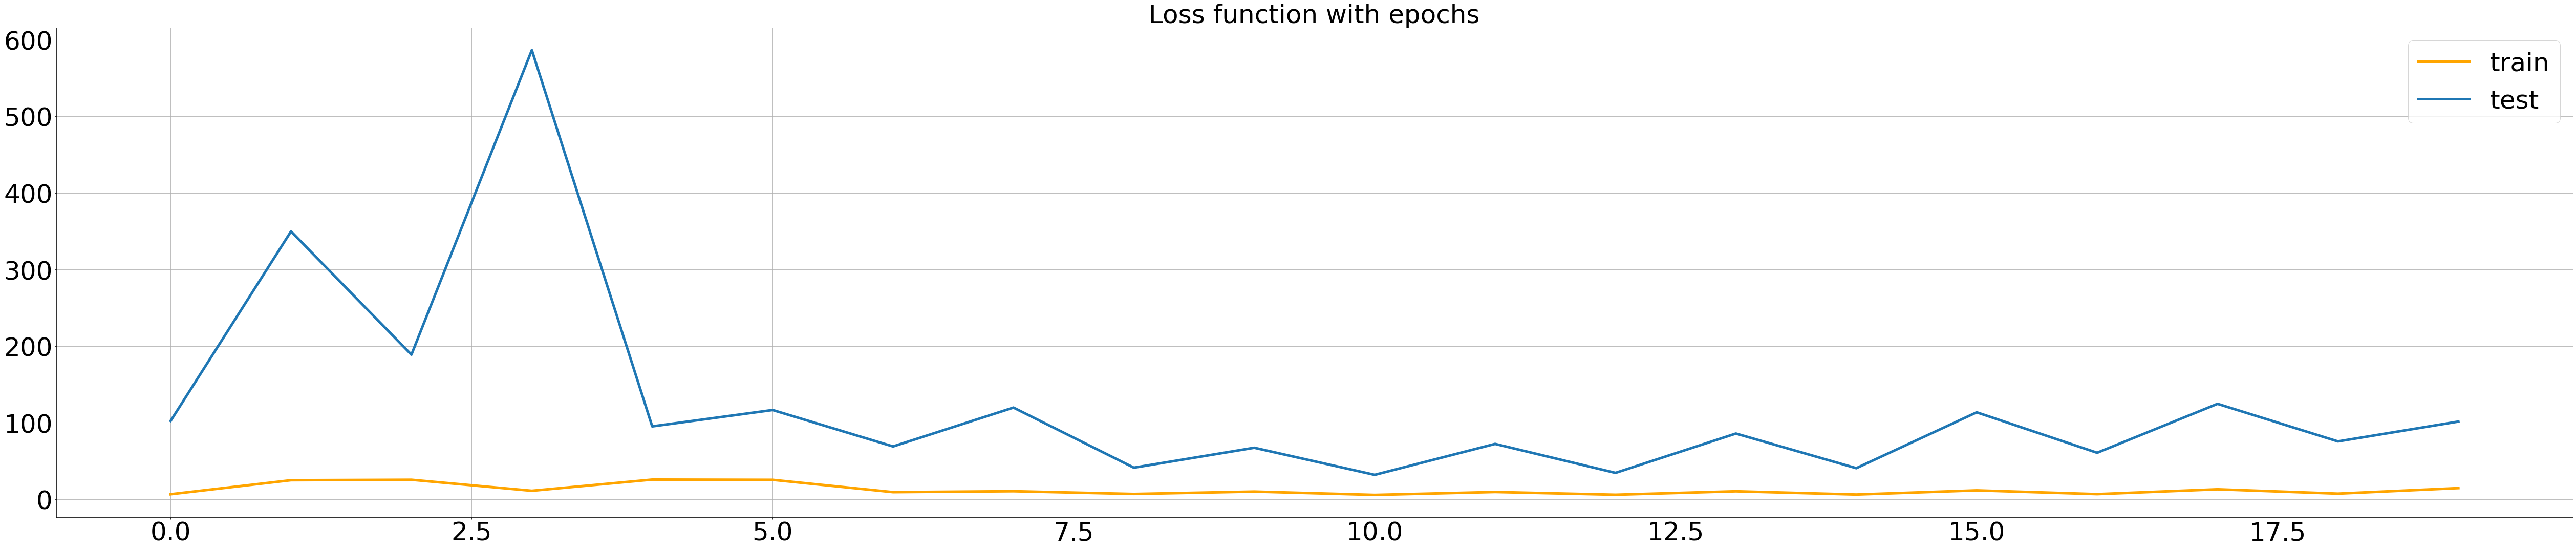

In [31]:
model = linearRegression(num_features, len(vanga.target), bias = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=0.01)

vanga.fit_data_torch(model = model, score=score_torch, optimizer=optimizer, scale = True, 
                     scheduler_1 = ExponentialLR(optimizer, gamma = 1),
                     scheduler_2 = MultiStepLR(optimizer, milestones = [], gamma = 0.01), 
                     batch_size = len(vanga.data)//70, max_epochs = 20, silent = False, tol = 1e-2,
                     first_linear_pretrained = True)

# Schedulers:
# StepLR(optimizer, step_size = 4, gamma = 0.1)
# ExponentialLR(optimizer, gamma = 0.1)
# MultiStepLR(optimizer, milestones = [4, 10, 15], gamma = 0.1)

vanga.predict_test()
#vanga.plot_one_region(region = 1)

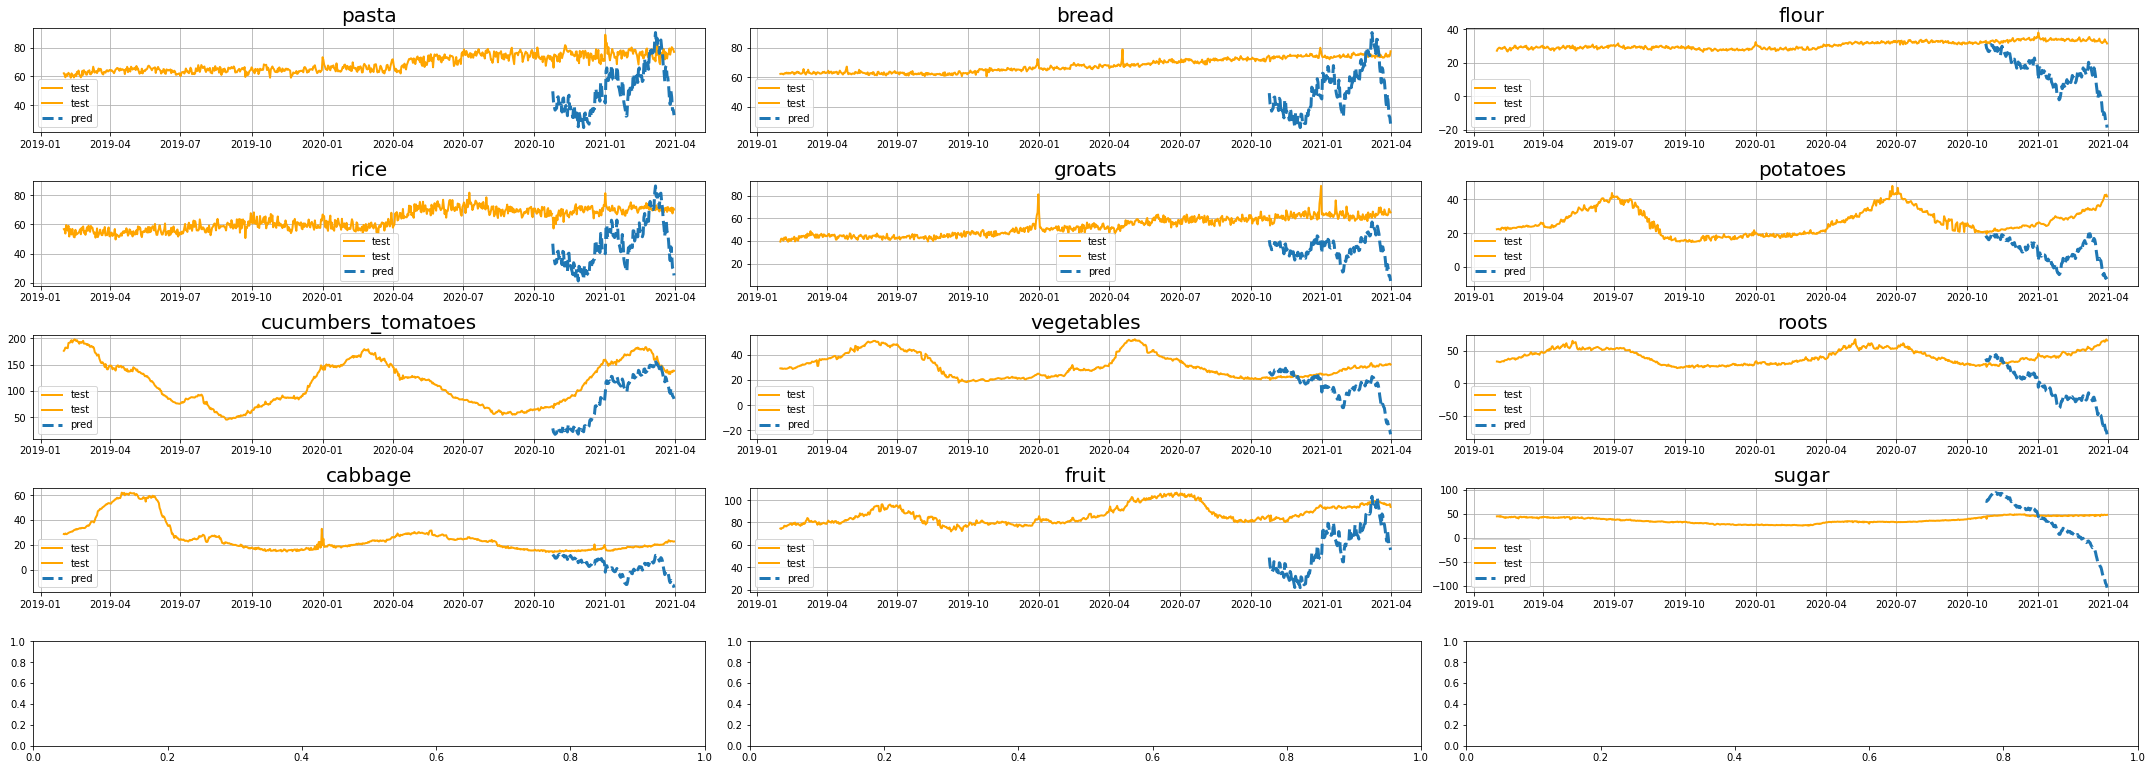

In [24]:
#vanga.predict_test()
vanga.plot_one_region(region = 2)

_________


# Batch_norm with not scaled/scaled data

# X is not scaled

### F.relu(self.linear_1(x)) X -- not scaled

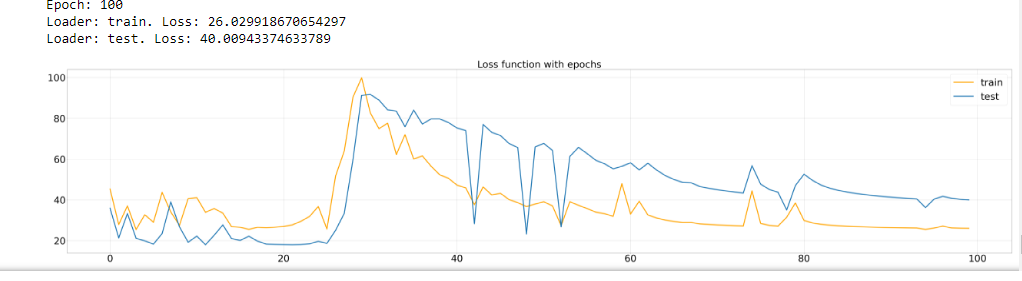

### self.bn(F.relu(self.linear_1(x))) X -- not scaled

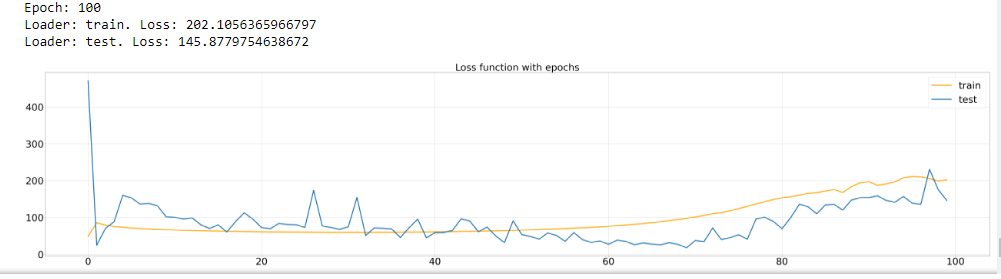

### F.relu(self.bn(self.linear_1(x)))) X -- not scaled

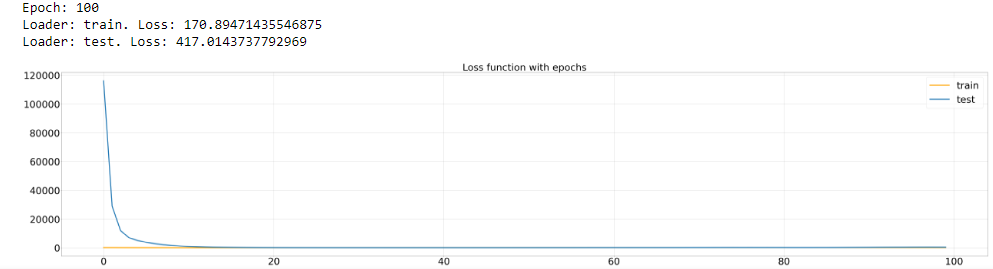


# X is scaled


### F.relu(self.linear_1(x)) X -- scaled

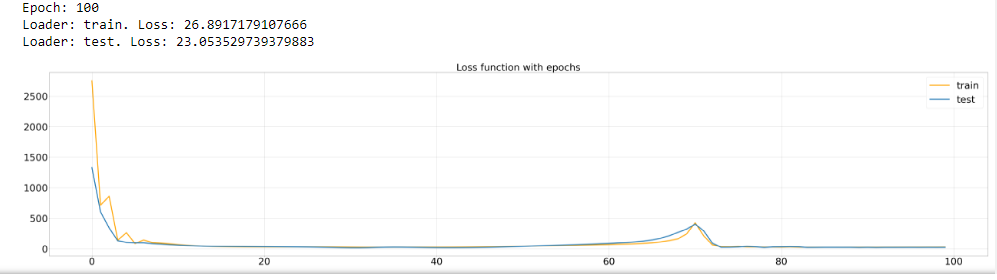

### self.bn(F.relu(self.linear_1(x))) X -- scaled

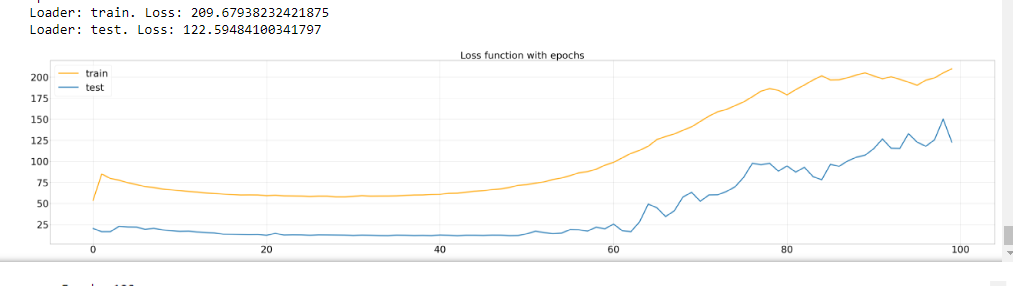

### F.relu(self.bn(self.linear_1(x))) X -- scaled

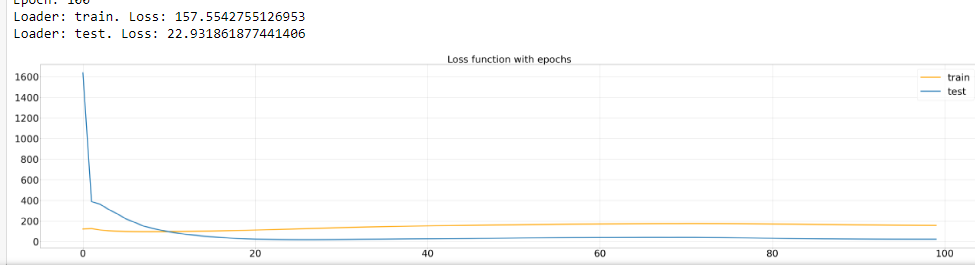

---------

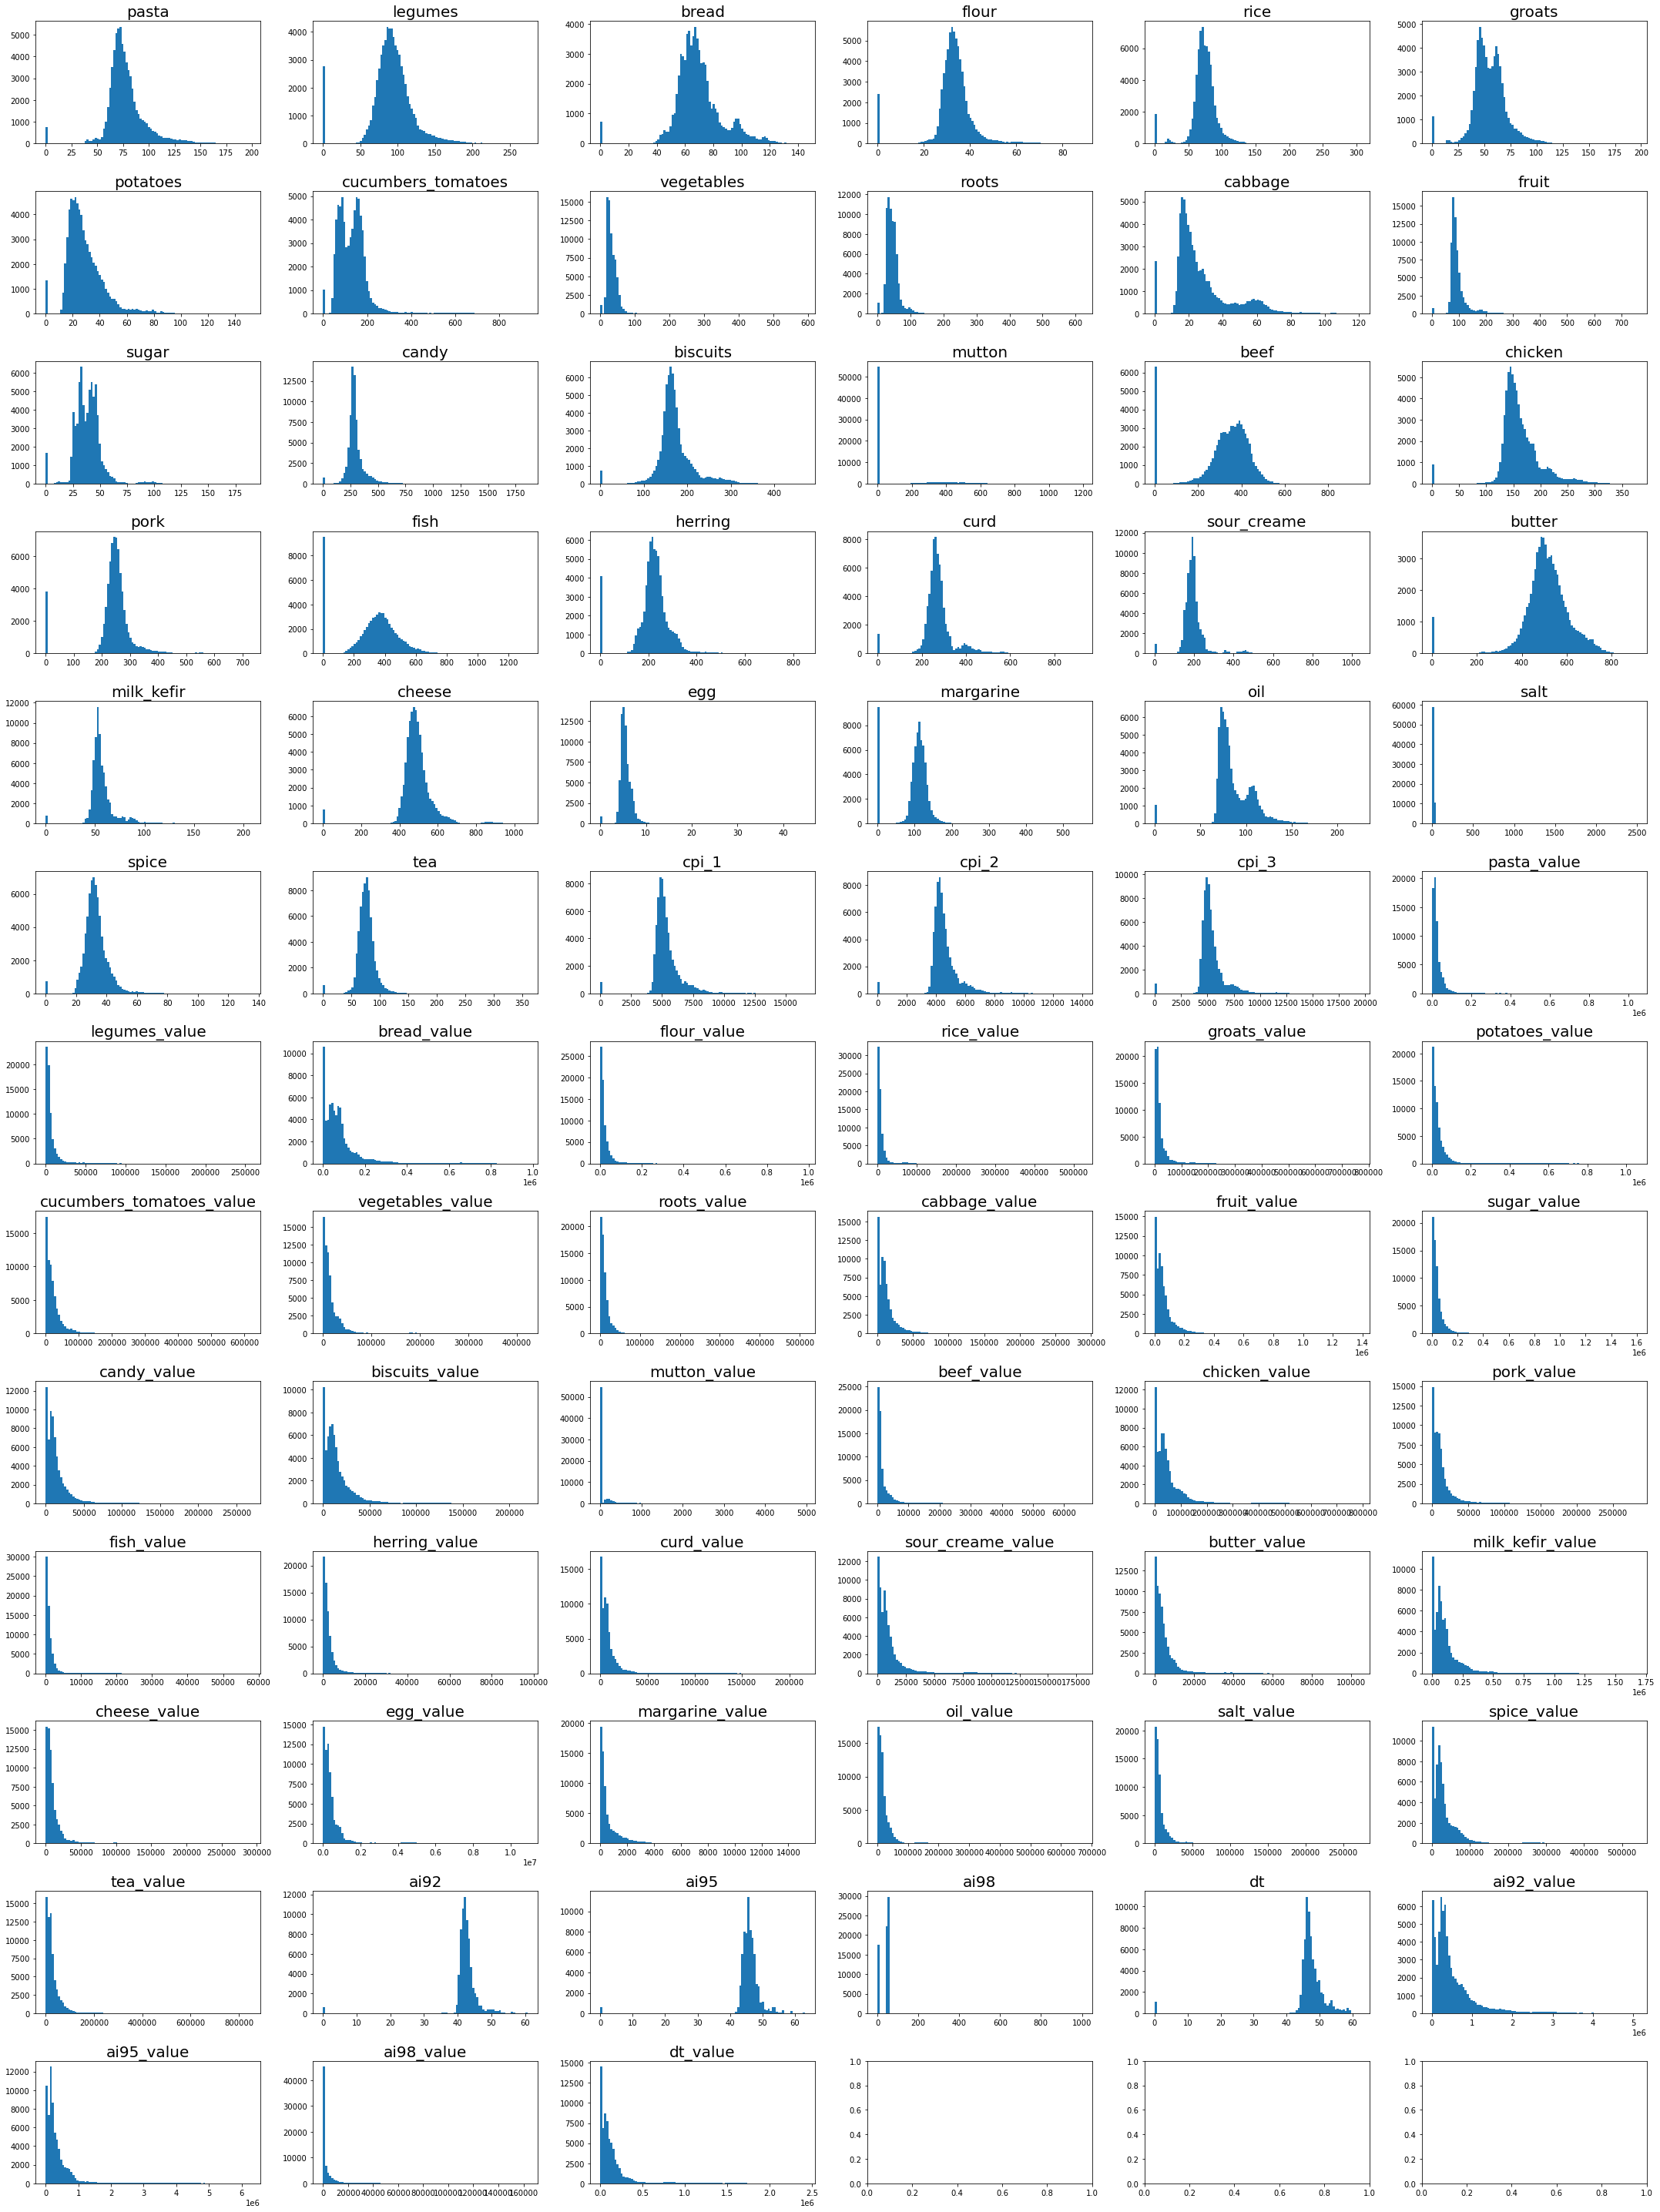

In [1099]:
# define the figure size and grid layout properties
figsize = (30, 40)
cols = 6
rows = len(columns) // cols + 1


fig, axs = plt.subplots(rows, cols, figsize=figsize)
axs = axs.flat
for ax, column in zip(axs, columns):
    ax.set_title(column, fontdict = {'fontsize': 20})
    ax.hist(data_train_1[column], bins=100)
    
plt.tight_layout()

Final def prepare_data_function
--------


Для работы с XGBoost придется анализировать тренды и сезонность, но пока что просто быстро взглянем, что у нас есть

In [ ]:
"""
plt.figure(figsize=(70, 15), tight_layout = True)
plt.plot(vanga.y_train, label = 'train',  linewidth = 5, color = 'orange')
plt.plot(vanga.y_test, label = 'test', linewidth = 5, color = 'orange')
plt.plot(pred_.drop(['region'], axis = 1), label = 'pred',  linewidth = 5, linestyle = 'dashed')
plt.title("{} for region № {}".format(vanga.target, vanga.region),  fontsize = 50)
plt.tick_params(axis='both', which='major', labelsize=50)
plt.grid(True)
plt.legend(fontsize = 50)
"""

<AxesSubplot:>

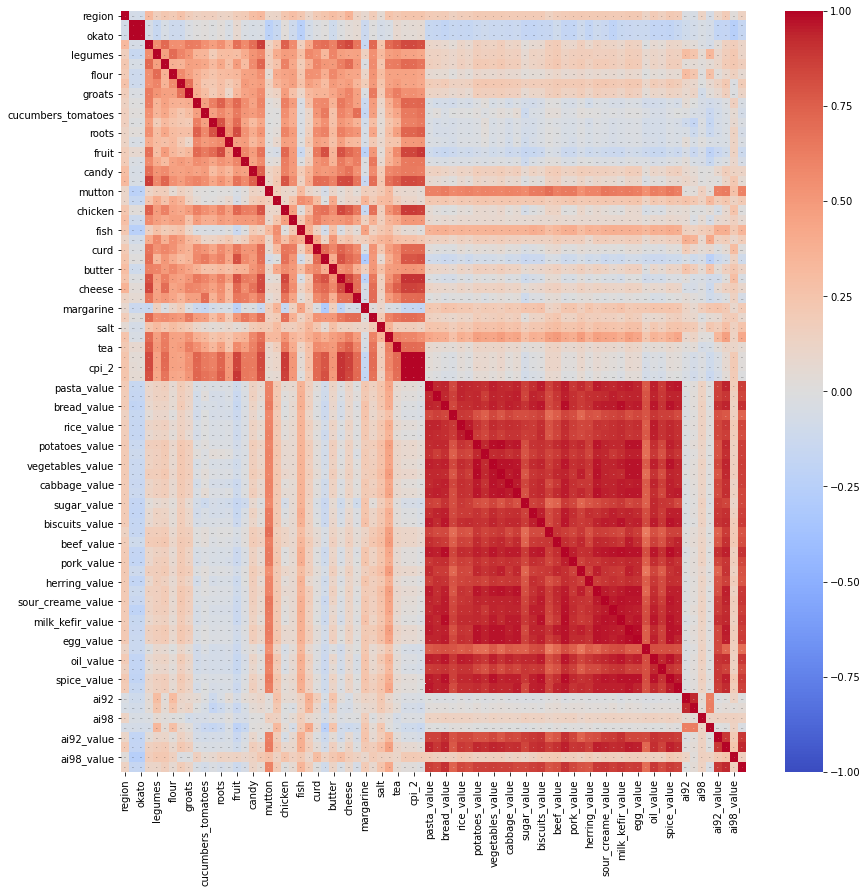

In [34]:
#plt.figure(figsize = (14,14))
#sns.heatmap(data_train_1.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 1})

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

----------------------

In [30]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

Попробуем LogisticRegressionCV

In [39]:
C = (100, 10, 1, 0.1, 0.01, 0.001)

In [40]:
cls = LogisticRegressionCV(Cs = C, cv = 5, scoring = 'roc_auc', refit = True, n_jobs = -1)

In [41]:
cls.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=(100, 10, 1, 0.1, 0.01, 0.001), cv=5, n_jobs=-1,
                     scoring='roc_auc')

In [42]:
y_predict = cls.predict_proba(X_test_scaled)[:, 1]

Точность и лучший параметр:

In [43]:
roc_auc_score(y_test, y_predict), cls.C_

(0.8438829912715263, array([10.]))

Качество на модели LogisticRegressionCV 

Точность предсказания = 0.8438, лучший параметр C = 10

-----------

Попробуем LogistricRegression + GridSearchCV

In [44]:
cls = make_pipeline(
    StandardScaler(),
    LogisticRegression())

parameters = [{'logisticregression__C' : [100, 10, 1, 0.1, 0.01, 0.001]}]

CV_model = GridSearchCV(estimator = cls, 
                            param_grid = parameters,
                            cv = 5, 
                            scoring = 'roc_auc',
                            n_jobs = -1,
                            verbose = 10, refit = True)
CV_model.fit(X.values, y.values)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'logisticregression__C': [100, 10, 1, 0.1, 0.01,
                                                    0.001]}],
             scoring='roc_auc', verbose=10)

Точность и лучший параметр:

In [45]:
roc_auc_score(y_test, CV_model.predict_proba(X_test)[:,1]), CV_model.best_params_

(0.8474970511913188, {'logisticregression__C': 100})

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

Лучшее качество получено на модели LogisticRegression + GridSearchCV 

Точность предсказания = 0.8475, лучший параметр C = 100

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [49]:
from catboost import CatBoostClassifier, Pool, cv

X_train, X_test, y_train, y_test = train_test_split(X_origin, y, 
                                                    train_size = 0.8,
                                                    random_state = 42)

model_cat = CatBoostClassifier(iterations = 1000,
                              depth = 10,
                              learning_rate = 0.5,
                              custom_loss = 'AUC',
                              cat_features = cat_cols, random_seed = 42, verbose = False)

model_cat.fit(X_train, y_train, 
          eval_set = (X_test, y_test),
          cat_features = cat_cols,
          plot = False)

print(f'Результат на тренировочной выборке: {roc_auc_score(y_test, model_cat.predict_proba(X_test)[:, 1])}')

Результат на тренировочной выборке: 0.8250601556970985


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

В итоге на каггл выложил предсказания линейной модели LogistricRegression + GridSearchCV

Для строк с плохими признаками обозначил целевую переменную за 0.5 (Дедлайн жмет, можно было, конечно, усреднить еще на этапе плохих признаков)

In [50]:
best_model = CV_model # какая-то предыдущая модель

In [51]:
submission = pd.read_csv('./submission.csv')

In [52]:
submission.loc[176:178]

,Id,Churn
176,176,0.5
177,177,0.5
178,178,0.5


In [53]:
submission_bad = submission.loc[bad_list_test].copy()

In [54]:
submission = submission.drop(bad_list_test)

In [55]:
submission['Churn'] = best_model.predict_proba(X_data_test)[:,1] # best_model.predict_proba(X_test) / best_model.predict(X_test)

In [ ]:
submission = pd.concat([submission, submission_bad])

In [56]:
submission.iloc[:,1:]

,Churn
0,0.037014
1,0.736054
2,0.682570
3,0.005713
4,0.001205
...,...
1756,0.098502
1757,0.025939
1758,0.750503
1759,0.644307


In [57]:
submission = submission.sort_index()

In [58]:
submission.to_csv('./my_submission.csv', index = False)

Нужно только не забыть добавить Id в название первой колонки!